<a href="https://colab.research.google.com/github/lauraluebbert/test_gget_alphafold/blob/dev/test_gget_alphafold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [gget alphafold](https://github.com/pachterlab/gget) test

___

Install and import gget:

In [ ]:
!pip install -q "mysql-connector-python>=8.0.32"
!pip install -q --no-cache-dir git+https://github.com/pachterlab/gget.git@dev

import gget

  Cloning https://github.com/pachterlab/gget.git (to revision main) to /tmp/pip-req-build-k8j_gskv
  Running command git clone --filter=blob:none --quiet https://github.com/pachterlab/gget.git /tmp/pip-req-build-k8j_gskv
  Resolved https://github.com/pachterlab/gget.git to commit dfd0755b0d2bc8d3def318c387e0cd82a689e48f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Install OpenMM:  

In [ ]:
import os, sys, subprocess, site, pathlib, textwrap
%config InlineBackend.figure_format='retina'

!pip install -q biopython

# For use with Amber relax
!pip install "numpy<1.24" --force-reinstall

# Force JAX to ignore CUDA plugins and use CPU
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Make sure GPU plugins are gone and JAX is on a matching CPU wheel
subprocess.run(f"{sys.executable} -m pip uninstall -y jax-cuda12-plugin jax-cuda12-pjrt jax_plugins", shell=True, check=False)
subprocess.run(f"{sys.executable} -m pip install -U 'jax==0.4.26' 'jaxlib==0.4.26'", shell=True, check=True)

# Install OpenMM 8
!pip install "openmm>=8,<9"

# Create a lightweight 'simtk' shim that re-exports OpenMM 8 symbols
site_pkgs = site.getsitepackages()[0]  # e.g., /usr/local/lib/python3.x/dist-packages
shim_root = pathlib.Path(site_pkgs) / "simtk"
(shim_root / "openmm" / "app").mkdir(parents=True, exist_ok=True)

# simtk/__init__.py
(shim_root / "__init__.py").write_text("")

# simtk/openmm/__init__.py -> re-export openmm 8 API
(shim_root / "openmm" / "__init__.py").write_text(textwrap.dedent("""\
    # Compatibility shim for legacy imports: `import simtk.openmm as openmm`
    from openmm import *  # re-export core openmm symbols
    from openmm import unit as unit  # provide `simtk.openmm.unit` attribute
    try:
        # make `from simtk.openmm import app` work via attribute
        from openmm import app as app
    except Exception:
        pass
"""))

# simtk/openmm/app/__init__.py -> re-export app layer
(shim_root / "openmm" / "app" / "__init__.py").write_text(textwrap.dedent("""\
    # Compatibility shim for: `from simtk.openmm.app import *`
    from openmm.app import *
"""))

# simtk/unit.py -> legacy `from simtk import unit`
(shim_root / "unit.py").write_text("from openmm.unit import *\n")

# Test the legacy imports
try:
    import simtk.openmm as openmm
    from simtk.openmm import app
    from simtk import unit
    print("Shim OK. OpenMM version:", openmm.version.version)
    # quick smoke test
    print("Has app.PDBFile:", hasattr(app, "PDBFile"))
    print("Has unit.nanometer:", hasattr(unit, "nanometer"))
except Exception as e:
    print("Shim/import failed:", repr(e))

Using Python 3.12.11 environment at: /usr
Resolved 1 package in 37ms
  × Failed to build `numpy==1.23.5`
  ├─▶ The build backend returned an error
  ╰─▶ Call to `setuptools.build_meta:__legacy__.build_wheel` failed (exit
      status: 1)

      [stderr]
      Traceback (most recent call last):
        File "<string>", line 8, in <module>
        File
      "/root/.cache/uv/builds-v0/.tmpbbXo1g/lib/python3.12/site-packages/setuptools/__init__.py",
      line 10, in <module>
          import distutils.core
      ModuleNotFoundError: No module named 'distutils'

      hint: `distutils` was removed from the standard library in Python 3.12.
      Consider adding a constraint (like `numpy >1.23.5`) to avoid building a
      version of `numpy` that depends on `distutils`.
Shim OK. OpenMM version: 8.3.1.dev-6e13f13
Has app.PDBFile: True
Has unit.nanometer: True


Install third-part dependencies and download AlphaFold model parameters using `gget setup` (this might take a few minutes):

In [ ]:
gget.setup("alphafold")

INFO:gget.utils:Attempting to install py3Dmol using: uv pip install -U py3Dmol
INFO:gget.utils:py3Dmol installed successfully using uv pip install -U py3Dmol.
INFO:gget.utils:Installing AlphaFold from source (requires pip and git).
INFO:gget.utils:AlphaFold installed succesfully.
INFO:gget.utils:Installing pdbfixer from source (requires pip and git).
INFO:gget.utils:pdbfixer installed succesfully.
INFO:gget.utils:AlphaFold model parameters already downloaded.


Predict the 3D structure of CASP14 target [T1024](https://predictioncenter.org/casp14/target.cgi?id=8&view=all):

INFO:gget.utils:Validating input sequence(s).
INFO:gget.utils:Using the single-chain (monomer) model.
INFO:gget.utils:Finding closest source for reference database.
Jackhmmer search: 100%|██████████| 199/199 [elapsed: 38:27 remaining: 00:00]
INFO:gget.utils:59 unique sequences found in uniref90 for sequence 1.
INFO:gget.utils:110 unique sequences found in smallbfd for sequence 1.
INFO:gget.utils:66 unique sequences found in mgnify for sequence 1.



230 unique sequences found in total for sequence 1



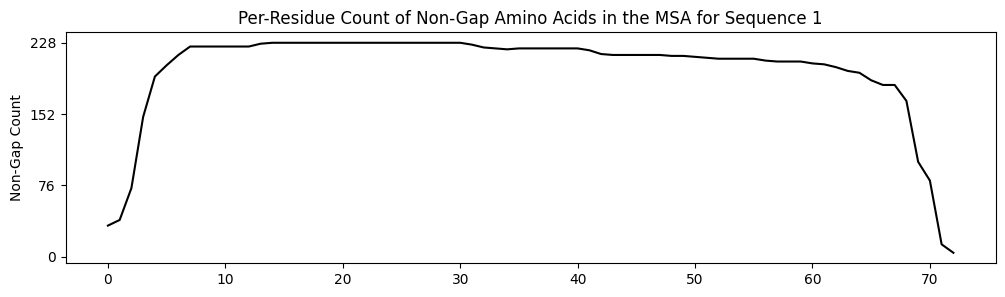

Running model_3:  29%|██▊       | 2/7 [elapsed: 2:36:40 remaining: 6:25:05]

In [ ]:
gget.alphafold(
    "MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH",
    relax=True,
    out=None
    )